Ομάδα: 50

Κωνσταντίνος Ριζάβας - 03117027

Κυριάκος Παναγιωτίδης - 03117206

# Installations, upgrades and imports

In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade scipy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn

     |████████████████████████████████| 2.1 MB 5.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.3/749.3 KB 36.5 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully 

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
from PIL import Image
from google.colab import drive
import pandas as pd
import nltk
from nltk.translate.bleu_score import SmoothingFunction
import seaborn as sns
from contextlib import contextmanager
from operator import itemgetter

# tf.config.experimental_run_functions_eagerly(True)

def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds(13)

drive.mount('/drive')
DRIVE_PATH = '/drive/MyDrive/Neural_Networks/lab3/'

Mounted at /drive


# Important note:
We will build the project largely based upon tensorflow tutorial https://www.tensorflow.org/tutorials/text/image_captioning which tries to solve the same problem with us. We will do some follow-up optimizations though and try to acquire even better results.

# Dataset

We download the dataset from the corresponding sites.

In [ ]:
# Download image files
PATH = '/content/image_dir/'
if not os.path.exists(PATH):
    image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                        cache_subdir=os.path.abspath('.'),
                                        origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                        extract=True)
    os.remove(image_zip)

# Download train captions file
train_captions_file = os.path.abspath('.') + "/train_captions.csv"
if not os.path.isfile(train_captions_file):
    train_captions_file = tf.keras.utils.get_file('train_captions.csv',
                                        cache_subdir=os.path.abspath('.'),
                                        origin='https://spartacus.1337.cx/flickr-mod/train_captions.csv',
                                        extract=False)

# Download test files list
test_images_file = os.path.abspath('.') + "/test_images.csv"
if not os.path.isfile(test_images_file):
    test_images_file = tf.keras.utils.get_file('test_images.csv',
                                        cache_subdir=os.path.abspath('.'),
                                        origin='https://spartacus.1337.cx/flickr-mod/test_images.csv',
                                        extract=False)
  
print('Finished loading data')

40960/29242 [==========================================] - 0s 0us/step
Finished loading data


# Tutorial

## Initial dataset preprocessing

We use pandas to read the `train_captions.csv` file and put it in a dataframe. We also parse the captions column to remove the leading blank space due to the file format.

In [ ]:
train_captions_df = pd.read_csv('./train_captions.csv', sep='|', header=None)

# Transpose df to access it normally: [row][column]
train_captions_df = train_captions_df.transpose()

for row in range(train_captions_df.shape[1]):
  # Erase leading blank due to the input file format
  train_captions_df[row][2] = train_captions_df[row][2][1:]

We create a dictionary with the images' paths as keys and the corresponding lists of captions as values.

In [ ]:
image_path_to_caption = collections.defaultdict(list)
for row in range(train_captions_df.shape[1]):
    caption = f'<start> {train_captions_df[row][2]} <end>'
    image_path = PATH + train_captions_df[row][0]
    image_path_to_caption[image_path].append(caption)

Now we shuffle the images and select 6000 to narrow down our dataset a bit.

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 images from the shuffled set.
# Each image id has 5 captions associated with it, so that will lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


We create 2 lists that match image to caption (the image list contains the image path multiple times, one for every caption it is associated with -  which is 5 times for the time being)

In [ ]:
train_captions = []
img_name_vector = []

for img_path in train_image_paths:
    caption_list = image_path_to_caption[img_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([img_path] * len(caption_list))

<start> A homeless man in a wheelchair is holding a cup out for a man to put some change into <end>


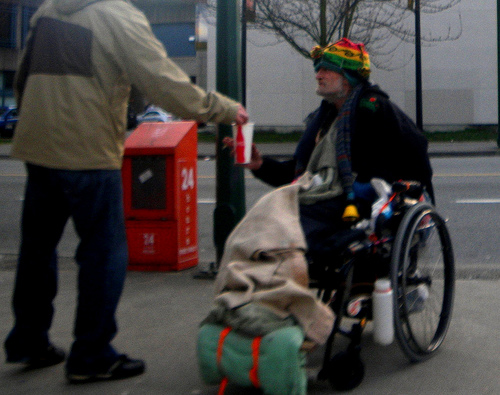

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocessing the images using InceptionV3

Next, we will use InceptionV3 (which is pretrained on Imagenet) to classify each image. We will extract features from the last convolutional layer.

First, we will convert the images into InceptionV3's expected format by:

* Resizing the image to 299px by 299px
* Preprocess the images using the preprocess_input method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now we'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is **8x8x2048**. We use the last convolutional layer because we are using attention in this example. We don't perform this initialization during training because it could become a bottleneck.

* We forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, we save the dictionary to disk.

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


## Caching the features extracted from InceptionV3

We will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 * 8 * 2048 floats per image

In [ ]:
!mkdir inceptionv3

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
      path_of_feature = '/content/inceptionv3/' + p.numpy().decode('utf-8').split('/')[-1]
      # path_of_feature = p.numpy().decode("utf-8")
      # path_of_feature = path_of_feature.split('/')[-1]
      # path_of_feature = '/content/inceptionv3/' + path_of_feature
      # print(path_of_feature)
      np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

We will transform the text captions into integer sequences using the TextVectorization layer, with the following steps:

* Use adapt to iterate over all captions, split the captions into words, and compute a vocabulary of the top 5,000 words (to save memory).
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(inputs, r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(max_tokens=vocabulary_size, standardize=standardize, output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)

## Split the data into training and testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys) * 0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Create a tf.data dataset for training

Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
    path_of_numpy = img_name.decode('utf-8') + '.npy'
    path_of_numpy = path_of_numpy.split('/')[-1]
    path_of_numpy = '/content/inceptionv3/' + path_of_numpy
    img_tensor = np.load(path_of_numpy)
    return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int64]), num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, we extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* We squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

!!! Note !!!

The classes have been a bit altered to be able to use them after choosing some optimizations in the latter parts of the code (mainly the RNN decoder).

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, dropout=False, embeddings_initialization=False, mode='GRU'):
        super(RNN_Decoder, self).__init__()
        self.units = units

        if embeddings_initialization:
          self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False)
        else:
          self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        if mode == 'GRU':
          self.unit_type = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        else:
          self.unit_type = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

        self.dropout_bool = dropout
        if dropout:
          self.drop = tf.keras.layers.Dropout(0.2)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.unit_type(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        if self.dropout_bool:
          # Add a dropout layer for regularization
          x = self.drop(x)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = DRIVE_PATH + 'checkpoints/tutorial/'
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective .npy files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.7228
Epoch 1 Batch 100 Loss 1.2766
Epoch 1 Batch 200 Loss 1.1289
Epoch 1 Batch 300 Loss 1.1454
Epoch 1 Loss 1.277891
Time taken for 1 epoch 261.09 sec

Epoch 2 Batch 0 Loss 1.0188
Epoch 2 Batch 100 Loss 0.9719
Epoch 2 Batch 200 Loss 1.0739
Epoch 2 Batch 300 Loss 1.0425
Epoch 2 Loss 1.013760
Time taken for 1 epoch 175.31 sec

Epoch 3 Batch 0 Loss 1.0237
Epoch 3 Batch 100 Loss 0.9087
Epoch 3 Batch 200 Loss 0.8594
Epoch 3 Batch 300 Loss 0.9767
Epoch 3 Loss 0.926331
Time taken for 1 epoch 175.37 sec

Epoch 4 Batch 0 Loss 0.8373
Epoch 4 Batch 100 Loss 0.8202
Epoch 4 Batch 200 Loss 0.7568
Epoch 4 Batch 300 Loss 0.9644
Epoch 4 Loss 0.865926
Time taken for 1 epoch 175.21 sec

Epoch 5 Batch 0 Loss 0.9955
Epoch 5 Batch 100 Loss 0.8308
Epoch 5 Batch 200 Loss 0.7557
Epoch 5 Batch 300 Loss 0.8272
Epoch 5 Loss 0.816199
Time taken for 1 epoch 175.15 sec

Epoch 6 Batch 0 Loss 0.7933
Epoch 6 Batch 100 Loss 0.7440
Epoch 6 Batch 200 Loss 0.7859
Epoch 6 Batch 300 Loss 0.7115
Epoch 6

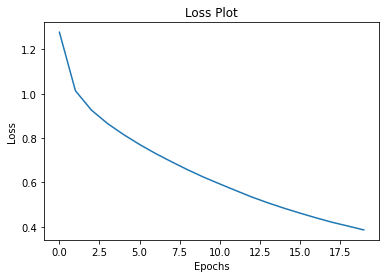

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption

* The evaluate function is similar to the training loop, except you don't use teacher forcing here.The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()

        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(20, 20))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> people ride up an escalator . <end>
Prediction Caption: two asian street in his right high in front of a stairwell of a tall white staircase in front of a tall white staircase . <end>


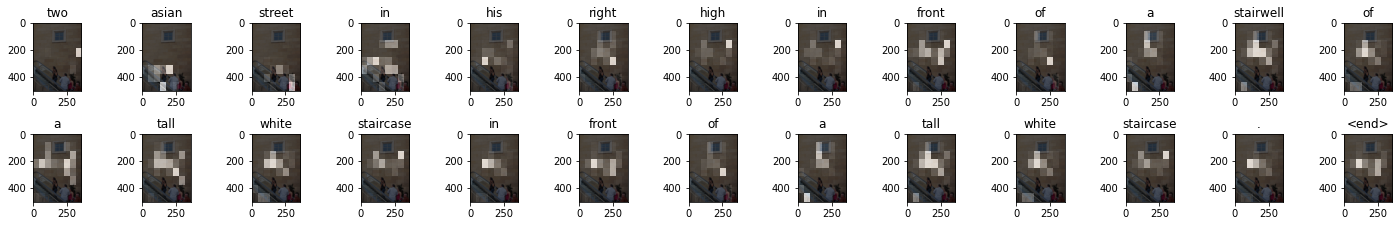

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Captioning Evaluation

The tutorial does not include some reference to the quality of the produced caption. If we suppose that every image has some corresponding real captions (references) and the neural network produces its own caption (hypothesis) we will use the BLEU (Bilingual Evaluation Understudy) score, between hypothesis and references.

BLEU is a weighted average of the quantity of mutual unigrams, bigrams, trigrams and fourgrams between hypothesis and references. The worse captioning gets a score of 0 and the best a score of 1.

The necessary functions are included in `nltk.translate.bleu_score`:

* To evaluate a single image we use ***sentence_bleu***
* To evaluate the whole validation set we will use ***corpus_bleu***

In all cases we will use: weights=(0.4, 0.3, 0.2, 0.1) and smoothing_function=SmoothingFunction().method1.

In [ ]:
def get_image_bleu(id):
  print('Image ID:', id)
  # # Show image for better evaluation
  # Image.open(img_name_val[id])

  print('Original references:')
  ref = []

  # Find the id (position in list) of the first caption of the image we are experimenting with
  while img_name_val[id - 1] == img_name_val[id] and id > 0:
    id -= 1

  for j in range(5):
    caption = [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[id + j] if i not in [0]]
    print(' '.join(caption))
    ref.append(caption[1:-1])

  print('Hypothesis:')
  my_image = img_name_val[id]
  result, attention_plot = evaluate(my_image)
  print(' '.join(result))
  my_score = nltk.translate.bleu_score.sentence_bleu(ref, result[:-1], weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=SmoothingFunction().method1)
  print('Sentence BLEU score =', my_score)
  plot_attention(my_image, result, attention_plot)

Example of a good bleu score (with a not that good caption)

Image ID: 1986
Original references:
<start> a group of men holding shovels and wearing hats are cleaning up a mess on the sidewalk . <end>
<start> city workers clean up a mess of garbage in the middle of a street . <end>
<start> men with shovels work to pick up a pile of dirt from a street . <end>
<start> [UNK] are busy at work , fixing a road . <end>
<start> a rod crew , of five , repairing a road . <end>
Hypothesis:
a group of men and men wearing a cleaning vegetables . <end>
Sentence BLEU score = 0.38665604528954567


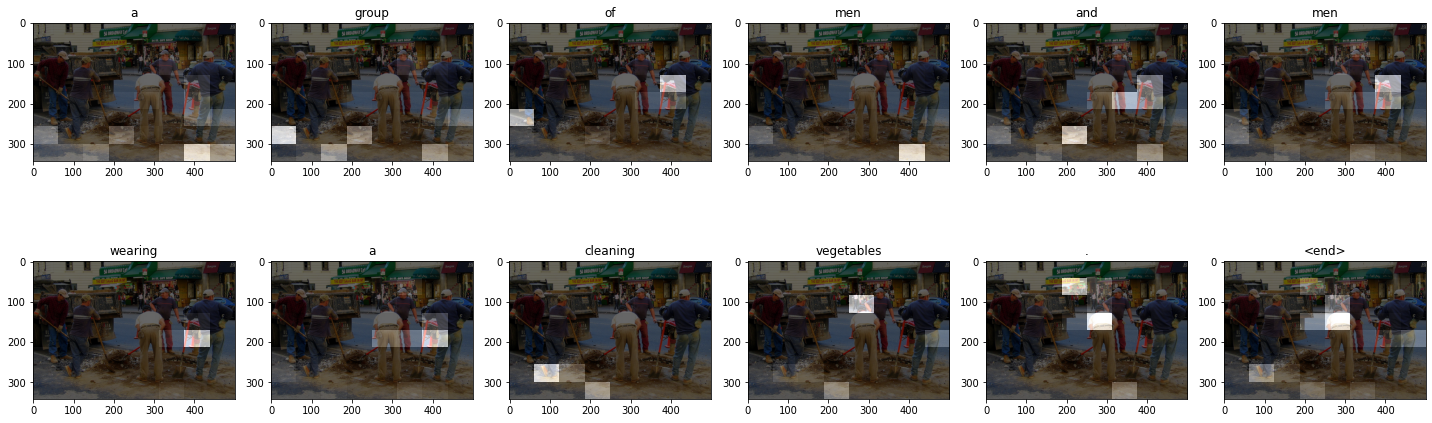

In [ ]:
id = 1986
get_image_bleu(id)

Example of a bad bleu score

Image ID: 1462
Original references:
<start> a man laying in the grass in front of two small cabins and a mountain drinking a soda . <end>
<start> a guy is lying down in front of some cabins , drinking something from a bottle . <end>
<start> a man in denim jeans lays on his back on the grass and enjoys a bottle of soda . <end>
<start> a woman lying in the grass taking drinking from an upside down bottle . <end>
<start> a young individual lays in the sun on a hill drinking a soda . <end>
Hypothesis:
a man is sitting on a trail through a sandy river in the mountains in the background . <end>
Sentence BLEU score = 0.10314770642657844


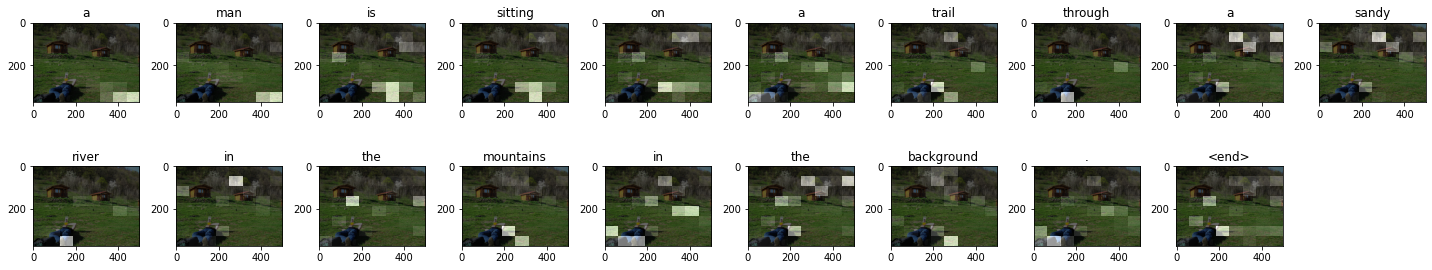

In [ ]:
id = 1462
get_image_bleu(id)

In [ ]:
def get_corpus_bleu(corpus):
  ref = []
  hypotheses = []
  for id in corpus:
    img_ref = []
    for j in range(5):
      caption = [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[id + j] if i not in [0]]
      img_ref.append(caption[1:-1])
    
    ref.append(img_ref)
    result, attention_plot = evaluate(img_name_val[id])
    hypotheses.append(result[:-1])

  my_score = nltk.translate.bleu_score.corpus_bleu(ref, hypotheses, weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=SmoothingFunction().method1)
  print('Corpus BLEU score =', my_score)

In [ ]:
get_corpus_bleu(list(range(0, 6000, 5)))

Corpus BLEU score = 0.10572330325171993


# Optimization

## Extra preprocessing of captions

First we plot a histogram how many words a caption is most likely to contain.

In [ ]:
lengths = []
for row in range(train_captions_df.shape[1]):
    counter = len(train_captions_df[row][2].split(' ')[:-1])
    lengths.append(counter)

Text(0, 0.5, 'Number of captions')

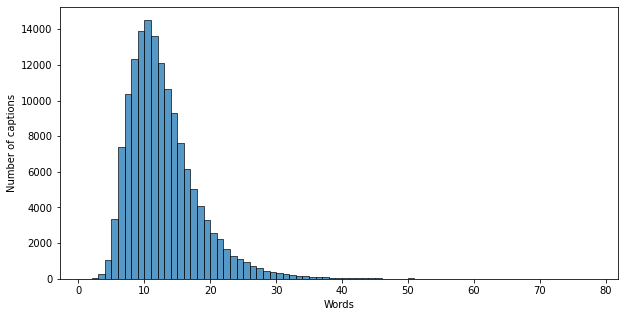

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(lengths, binwidth=1)
ax.set_xlabel('Words')
ax.set_ylabel('Number of captions')

We choose to work using only captions whose lengths are between 3 and 28 words.

In [ ]:
image_path_to_caption = collections.defaultdict(list)
for row in range(train_captions_df.shape[1]):
    words = len(train_captions_df[row][2].split(' ')[:-1])

    if words >= 3 and words <= 28:
      caption = f'<start> {train_captions_df[row][2]} <end>'
      image_path = PATH + train_captions_df[row][0]
      image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 images from the shuffled set.
# Each image id has ~5 captions associated with it, so that will lead to ~30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [ ]:
train_captions = []
img_name_vector = []

for i in train_image_paths:
    caption_list = image_path_to_caption[i]
    train_captions.extend(caption_list)
    img_name_vector.extend([i] * len(caption_list))

## Preprocessing the images using Xception

Now we will use the Xception trained model that is known to give better results than Inceptionv3. We will extract our features using only the last convolutional layer (top level).

First, we need to transform the images to the input format expected by Xception:

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

83697664/83683744 [==============================] - 1s 0us/step


## Caching the features extracted from Xception

We create a directory inside which we cache the features we acquire from our encoder model.

In [ ]:
!mkdir xception

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = '/content/xception/' + p.numpy().decode('utf-8').split('/')[-1]
        np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(inputs, r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 8000 words for a vocabulary.
vocabulary_size = 8000
tokenizer = tf.keras.layers.TextVectorization(max_tokens=vocabulary_size, standardize=standardize, output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)

## Split the data into training and testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys) * 0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(23644, 23644, 5903, 5903)

## Create a tf.data dataset for training

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 300
units = 1024
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from Xception is (100, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 100

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
    path_of_numpy = img_name.decode('utf-8') + '.npy'
    path_of_numpy = path_of_numpy.split('/')[-1]
    path_of_numpy = '/content/xception/' + path_of_numpy
    img_tensor = np.load(path_of_numpy)
    return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int64]), num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Load and parse the file with the new embeddings we downloaded

In [ ]:
path_to_glove_embeddings = DRIVE_PATH + 'glove.6B.300d.txt'

embeddings_index = {}
with open(path_to_glove_embeddings) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
voc = tokenizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc)
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

Converted 7652 words (348 misses)


## Model

The model is different given the different parameters we give to our classes.

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size(), dropout=True, embeddings_initialization=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = DRIVE_PATH + 'checkpoints/train/'
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.5473
Epoch 1 Batch 100 Loss 1.1988
Epoch 1 Batch 200 Loss 1.0825
Epoch 1 Batch 300 Loss 1.0514
Epoch 1 Loss 1.175509
Time taken for 1 epoch 504.97 sec

Epoch 2 Batch 0 Loss 0.9973
Epoch 2 Batch 100 Loss 0.9924
Epoch 2 Batch 200 Loss 1.0545
Epoch 2 Batch 300 Loss 0.8804
Epoch 2 Loss 0.957697
Time taken for 1 epoch 381.96 sec

Epoch 3 Batch 0 Loss 1.0066
Epoch 3 Batch 100 Loss 0.9257
Epoch 3 Batch 200 Loss 0.8912
Epoch 3 Batch 300 Loss 0.8860
Epoch 3 Loss 0.869061
Time taken for 1 epoch 375.59 sec

Epoch 4 Batch 0 Loss 0.9129
Epoch 4 Batch 100 Loss 0.8440
Epoch 4 Batch 200 Loss 0.7812
Epoch 4 Batch 300 Loss 0.7678
Epoch 4 Loss 0.802376
Time taken for 1 epoch 374.89 sec

Epoch 5 Batch 0 Loss 0.7765
Epoch 5 Batch 100 Loss 0.7384
Epoch 5 Batch 200 Loss 0.7504
Epoch 5 Batch 300 Loss 0.6691
Epoch 5 Loss 0.745724
Time taken for 1 epoch 374.98 sec

Epoch 6 Batch 0 Loss 0.8000
Epoch 6 Batch 100 Loss 0.7098
Epoch 6 Batch 200 Loss 0.7682
Epoch 6 Batch 300 Loss 0.6906
Epoch 6

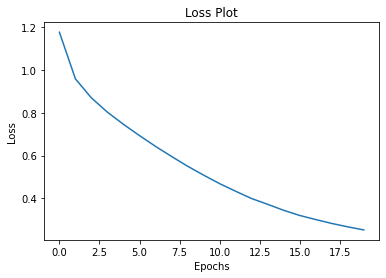

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption using beam-search

Beam search is known to give much better results overall. It is defined by a hyperparameter b (beam width) which defines how many "best" words to keep in mind. For every one of those words we then calculate the probabilities of all the possible next words and keep the b best combinations out of all of the possible ones. We continue like that until we finish. In the end we can use the sum of the log probabilities of every word divided by the length of the sentence generated to decide which one of the k sentences we found to keep.

In [ ]:
def beam_search_evaluate(image, beam_width=3):
    # Initializations
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)

    # Load the image, extract its features and shape it accordingly
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    
    result = []
    next_k_beams = [(dec_input, hidden, result, attention_plot, [])]
    k = beam_width
    final_k_beams = []

    # For every possible word we need to predict (up to max length)
    for i in range(max_length):
        # Let's calculate every possible step for every possibility we have up until now
        all_next_beams = []
        for dec_input, hidden, result, attention_plot, probabilities in next_k_beams:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            predictions = tf.nn.softmax(predictions)

            # For every possible step we choose the best k words (might need all of them)
            predicted_ids = [id for id in tf.math.top_k(predictions, k).indices[0].numpy()]
            predicted_probabilities = [p for p in tf.math.top_k(predictions, k).values[0].numpy()]
            predicted_words = [tf.compat.as_text(index_to_word(id).numpy()) for id in predicted_ids]

            for word, probability in zip(predicted_words, predicted_probabilities):
                new_result = result.copy()
                new_result.append(word)

                new_probabilities = probabilities.copy()
                new_probabilities.append(probability)

                attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
                dec_input = tf.expand_dims([word_to_index(word)], 0)

                all_next_beams.append((dec_input, hidden, new_result, attention_plot, new_probabilities))

        # Choose between the steps of all the previous inputs and keep the best k
        all_next_beams = sorted(all_next_beams, key=lambda x: np.prod(x[4]), reverse=True)
        next_k_beams = all_next_beams[:k]

        # We end the search if we find k sentences that end with a '.'
        for dec_input, hidden, result, attention_plot, probabilities in next_k_beams:
            if result[-1] == '.':
                final_k_beams.append((result, attention_plot, probabilities))
            if len(final_k_beams) == k:
                break

        if len(final_k_beams) == k:
            break

        # And we choose and remove the finished sentences from our search
        next_k_beams = [beam for beam in next_k_beams if beam[2][-1] != '.']

    # At this point we reached the max length and we didn't find k finished sentences, so we choose the best (k - finished) sentences to fill the last remaining positions
    if len(final_k_beams) < k:
        temp_beams = []
        for dec_input, hidden, result, attention_plot, probabilities in next_k_beams:
            temp_beams.append((result, attention_plot, probabilities))
        final_k_beams = final_k_beams + temp_beams[:k-len(final_k_beams)]

    # Decide the final best prediction
    final_k_beams_log = []
    for result, attention_plot, probabilities in final_k_beams:
        sum = 0
        for probability in probabilities:
            sum += np.log(probability)
        log_probability = sum / len(result)
        final_k_beams_log.append((result, attention_plot, log_probability))

    best_beam = sorted(final_k_beams_log, key=lambda x: x[2])[-1]
    caption = best_beam[0]
    
    # Add a '.' in case it's a max length sentence + an ending token
    if caption[-1] != '.':
        caption.append('.')
    caption.append('<end>')

    attention_plot = best_beam[1][:len(best_beam[0]), :]

    return caption, attention_plot

Real Caption: <start> a young man in a green shirt standing at the side of the street next to a vehicle with a child inside . <end>
Prediction Caption: a man in a white shirt looks at something . <end>


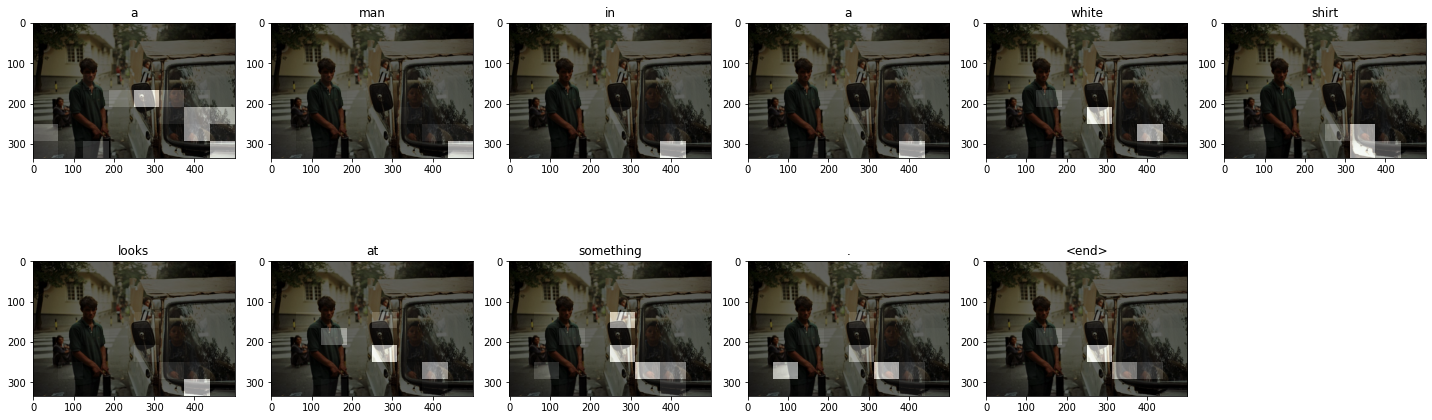

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]])
result, attention_plot = beam_search_evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Captioning Evaluation

In [ ]:
def get_image_bleu_new(id):
  print('Image ID:', id)
  # # Show image for better evaluation
  # Image.open(img_name_val[id])

  print('Original references:')
  ref = []

  # Find the id (position in list) of the first caption of the image we are experimenting with
  while img_name_val[id - 1] == img_name_val[id] and id > 0:
    id -= 1

  for j in range(5):
    caption = [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[id + j] if i not in [0]]
    print(' '.join(caption))
    ref.append(caption[1:-1])

  print('Hypothesis:')
  my_image = img_name_val[id]
  result, attention_plot = beam_search_evaluate(my_image)
  print(' '.join(result))
  my_score = nltk.translate.bleu_score.sentence_bleu(ref, result[:-1], weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=SmoothingFunction().method1)
  print('Sentence BLEU score =', my_score)
  plot_attention(my_image, result, attention_plot)

Example of a decent bleu score

Image ID: 1986
Original references:
<start> a group of men holding shovels and wearing hats are cleaning up a mess on the sidewalk . <end>
<start> city workers clean up a mess of garbage in the middle of a street . <end>
<start> men with shovels work to pick up a pile of dirt from a street . <end>
<start> [UNK] are busy at work , fixing a road . <end>
<start> a rod crew , of five , repairing a road . <end>
Hypothesis:
a group of people standing outside in front of a poor country . <end>
Sentence BLEU score = 0.201170984203441


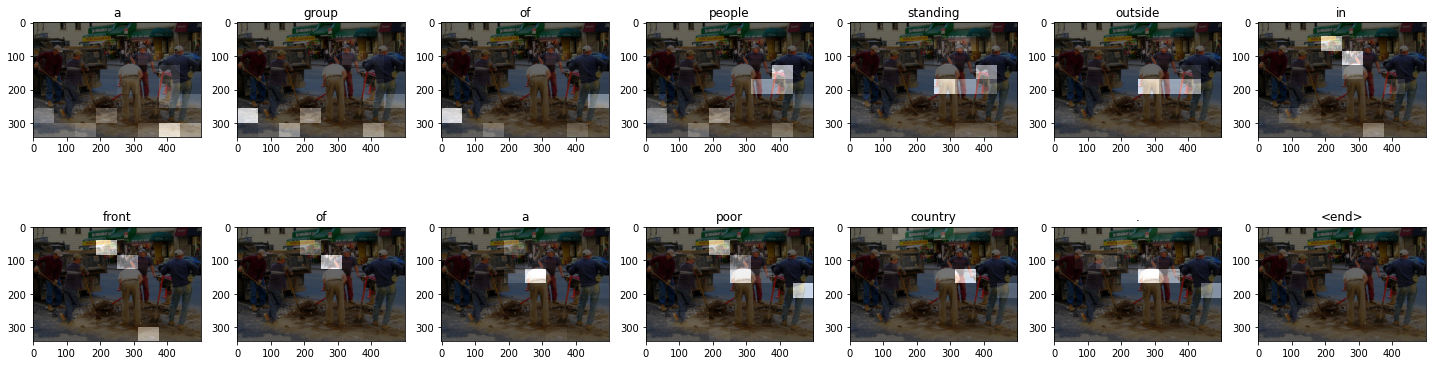

In [ ]:
id = 1986
get_image_bleu_new(id)

Example of a bad bleu score (with a not so bad caption)

Image ID: 1462
Original references:
<start> a man laying in the grass in front of two small cabins and a mountain drinking a soda . <end>
<start> a guy is lying down in front of some cabins , drinking something from a bottle . <end>
<start> a man in denim jeans lays on his back on the grass and enjoys a bottle of soda . <end>
<start> a woman lying in the grass taking drinking from an upside down bottle . <end>
<start> a young individual lays in the sun on a hill drinking a soda . <end>
Hypothesis:
a man is laying down in the background . <end>
Sentence BLEU score = 0.11578143452048985


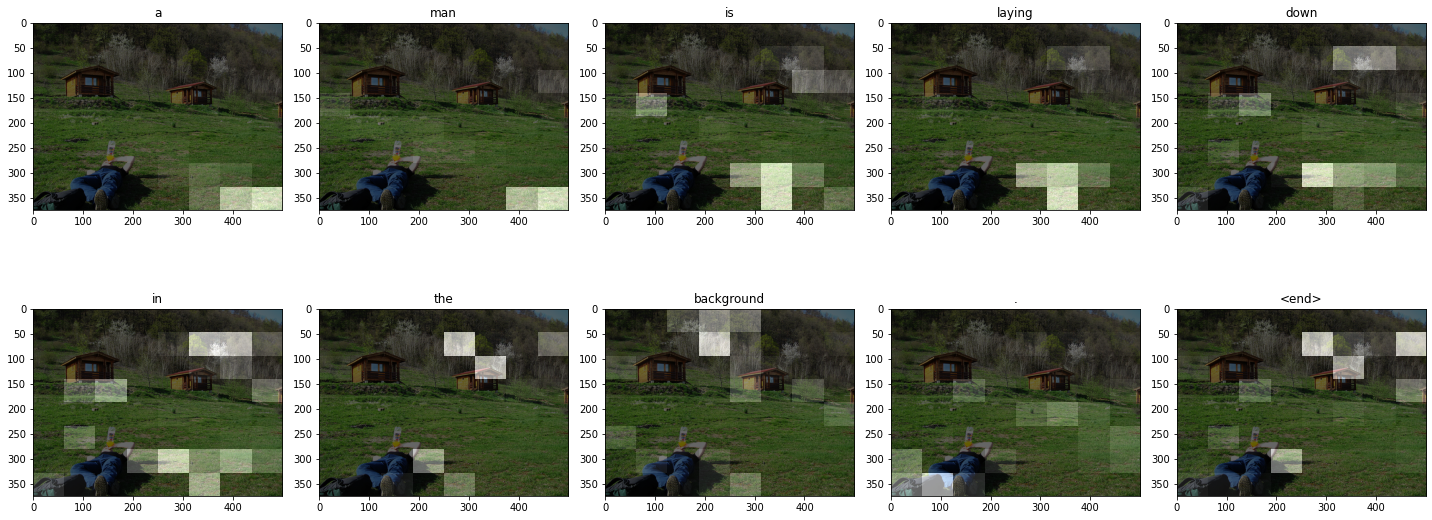

In [ ]:
id = 1462
get_image_bleu_new(id)

In [ ]:
def get_corpus_bleu_new(corpus):
  ref = []
  hypotheses = []
  id = 0
  while id < len(corpus):

    # Find the id (position in list) of the first caption of the image we are experimenting with
    counter = 1
    original_id = id
    while id < len(img_name_val) - 1:
      if img_name_val[id] == img_name_val[id + 1]:
        counter += 1
        id += 1
      else:
        break

    img_ref = []
    for j in range(counter):
      caption = [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[original_id + j] if i not in [0]]
      img_ref.append(caption[1:-1])
    
    ref.append(img_ref)
    result, attention_plot = beam_search_evaluate(img_name_val[original_id])
    hypotheses.append(result[:-1])

    if id % 500 < 5:
      temp = (id // 500) * 500
      print(f'Done: {temp} / {len(img_name_val)}')

    id += 1

  my_score = nltk.translate.bleu_score.corpus_bleu(ref, hypotheses, weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=SmoothingFunction().method1)
  print('Corpus BLEU score =', my_score)

In [ ]:
get_corpus_bleu_new(list(range(0, len(img_name_val))))

Done: 0 / 5903
Done: 500 / 5903
Done: 1000 / 5903
Done: 1500 / 5903
Done: 2000 / 5903
Done: 2500 / 5903
Done: 3000 / 5903
Done: 3500 / 5903
Done: 4000 / 5903
Done: 4500 / 5903
Done: 4500 / 5903
Done: 5000 / 5903
Done: 5500 / 5903
Corpus BLEU score = 0.11739202143259317
